# **Kasundi**- ResNet50 (transfer + small unfreeze)

In [4]:
# Check GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [5]:
# Basic deps for the split script + training
!pip -q install pandas scikit-learn tqdm


In [1]:
#1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
#2) Define paths to your files in root of My Drive and copy to fast local SSD
# Paths on Drive (root)
ZIP1 = "/content/drive/MyDrive/HAM10000_images_part_1.zip"
ZIP2 = "/content/drive/MyDrive/HAM10000_images_part_2.zip"
META = "/content/drive/MyDrive/HAM10000_metadata.csv"

# Local working area on Colab SSD
WORK     = "/content/work"
RAW_DIR  = f"{WORK}/raw"
EXTRACT  = f"{WORK}/ham10000_extracted"
DATA_DIR = f"{WORK}/data"

import os, subprocess, pathlib
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(EXTRACT, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Copy only if missing (fast on later sessions)
print(subprocess.getoutput(f'rsync -ah --ignore-existing "{ZIP1}" "{ZIP2}" "{META}" "{RAW_DIR}/"'))
print("Local RAW_DIR:", subprocess.getoutput(f'ls -lh "{RAW_DIR}"'))


Local RAW_DIR: total 2.6G
-rw------- 1 root root 1.3G Sep 29 15:20 HAM10000_images_part_1.zip
-rw------- 1 root root 1.4G Sep 29 15:18 HAM10000_images_part_2.zip
-rw------- 1 root root 551K Oct  6  2019 HAM10000_metadata.csv


In [6]:
#3) Unzip locally (NOT to Drive)
!mkdir -p /content/work/ham10000_extracted
!unzip -q /content/work/raw/HAM10000_images_part_1.zip -d /content/work/ham10000_extracted/
!unzip -q /content/work/raw/HAM10000_images_part_2.zip -d /content/work/ham10000_extracted/
!ls -lh /content/work/ham10000_extracted | head

total 328K
drwxr-xr-x 2 root root 156K Sep 29 20:38 HAM10000_images_part_1
drwxrwxrwx 2 root root 164K Sep 29 15:08 HAM10000_images_part_2


In [7]:
!mkdir -p /content/scripts

In [8]:
%%writefile /content/scripts/split_ham10000.py
#!/usr/bin/env python3
import argparse, os, shutil, zipfile
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def unzip_if_needed(zip_path: Path, extract_dir: Path):
    extract_dir.mkdir(parents=True, exist_ok=True)
    # If any jpgs already exist anywhere under extract_dir, skip
    if any(extract_dir.rglob("*.jpg")):
        print(f"[skip] Images already present under: {extract_dir}")
        return
    assert zip_path.exists(), f"Missing: {zip_path}"
    print(f"[unzip] {zip_path.name} -> {extract_dir}")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)

def index_images(img_root: Path):
    """
    Build a dict: image_id (without .jpg) -> full path
    Recurses under img_root to handle both 'HAM10000_images' and '..._part_1/part_2' layouts.
    """
    mapping = {}
    for p in img_root.rglob("*.jpg"):
        mapping[p.stem] = str(p)
    return mapping

def build_splits(meta_csv: Path, img_root: Path, train_pct: float, val_pct: float, test_pct: float, seed: int):
    assert abs((train_pct + val_pct + test_pct) - 1.0) < 1e-6, "Splits must sum to 1.0"
    meta = pd.read_csv(meta_csv)
    img_map = index_images(img_root)
    meta["image_path"] = meta["image_id"].map(img_map)
    meta = meta.dropna(subset=["image_path"]).copy()

    # quick sanity
    print(f"[info] Found {len(img_map)} jpgs under {img_root}")
    print(f"[info] Matched rows with metadata: {len(meta)}")

    train_df, temp_df = train_test_split(
        meta, test_size=1.0-train_pct, stratify=meta["dx"], random_state=seed
    )
    test_rel = test_pct / (val_pct + test_pct)
    val_df, test_df = train_test_split(
        temp_df, test_size=test_rel, stratify=temp_df["dx"], random_state=seed
    )
    return train_df, val_df, test_df, sorted(meta["dx"].unique())

def materialize_split(df: pd.DataFrame, split_name: str, out_root: Path):
    base = out_root / split_name
    base.mkdir(parents=True, exist_ok=True)
    for cls in sorted(df["dx"].unique()):
        (base / cls).mkdir(parents=True, exist_ok=True)
    for _, r in tqdm(df.iterrows(), total=len(df), desc=f"{split_name:>5}", unit="img"):
        src = Path(r["image_path"])
        dst = base / r["dx"] / src.name
        if not dst.exists():
            shutil.copy2(src, dst)

def print_counts(data_dir: Path):
    for split in ["train", "val", "test"]:
        base = data_dir / split
        if base.exists():
            counts = {
                d.name: len(list((base / d).glob("*")))
                for d in base.iterdir() if d.is_dir()
            }
            print(split, counts)

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--project_dir", default=".")
    p.add_argument("--train", type=float, default=0.8)
    p.add_argument("--val",   type=float, default=0.1)
    p.add_argument("--test",  type=float, default=0.1)
    p.add_argument("--seed",  type=int, default=42)
    p.add_argument("--clean", action="store_true")
    args = p.parse_args()

    project = Path(args.project_dir).resolve()
    raw_dir  = project / "raw"
    data_dir = project / "data"
    extract  = project / "ham10000_extracted"   # we recurse under this folder
    imgs_root = extract                         # <-- recursive root

    part1 = raw_dir / "HAM10000_images_part_1.zip"
    part2 = raw_dir / "HAM10000_images_part_2.zip"
    meta  = raw_dir / "HAM10000_metadata.csv"

    extract.mkdir(parents=True, exist_ok=True)
    data_dir.mkdir(parents=True, exist_ok=True)

    unzip_if_needed(part1, extract)
    unzip_if_needed(part2, extract)

    train_df, val_df, test_df, classes = build_splits(
        meta, imgs_root, args.train, args.val, args.test, args.seed
    )

    if args.clean:
        for s in ["train", "val", "test"]:
            target = data_dir / s
            if target.exists():
                shutil.rmtree(target)

    materialize_split(train_df, "train", data_dir)
    materialize_split(val_df, "val", data_dir)
    materialize_split(test_df, "test", data_dir)
    print_counts(data_dir)
    print("[done] Data ready at:", data_dir)

if __name__ == "__main__":
    main()

Writing /content/scripts/split_ham10000.py


In [9]:
!python /content/scripts/split_ham10000.py \
  --project_dir "/content/work" \
  --train 0.8 --val 0.1 --test 0.1 --seed 42 --clean

[skip] Images already present under: /content/work/ham10000_extracted
[skip] Images already present under: /content/work/ham10000_extracted
[info] Found 10015 jpgs under /content/work/ham10000_extracted
[info] Matched rows with metadata: 10015
train: 100% 8012/8012 [00:20<00:00, 398.05img/s]
  val: 100% 1001/1001 [00:03<00:00, 333.12img/s]
 test: 100% 1002/1002 [00:02<00:00, 346.28img/s]
train {'vasc': 114, 'mel': 890, 'akiec': 262, 'nv': 5364, 'bcc': 411, 'bkl': 879, 'df': 92}
val {'vasc': 14, 'mel': 111, 'akiec': 33, 'nv': 670, 'bcc': 51, 'bkl': 110, 'df': 12}
test {'vasc': 14, 'mel': 112, 'akiec': 32, 'nv': 671, 'bcc': 52, 'bkl': 110, 'df': 11}
[done] Data ready at: /content/work/data


In [10]:
#Quick sanity check:
import os
for split in ("train","val","test"):
    base = os.path.join("/content/work/data", split)
    classes = [d for d in sorted(os.listdir(base)) if os.path.isdir(os.path.join(base,d))]
    counts = {c: len(os.listdir(os.path.join(base,c))) for c in classes}
    print(split, counts)

train {'akiec': 262, 'bcc': 411, 'bkl': 879, 'df': 92, 'mel': 890, 'nv': 5364, 'vasc': 114}
val {'akiec': 33, 'bcc': 51, 'bkl': 110, 'df': 12, 'mel': 111, 'nv': 670, 'vasc': 14}
test {'akiec': 32, 'bcc': 52, 'bkl': 110, 'df': 11, 'mel': 112, 'nv': 671, 'vasc': 14}


In [ ]:
#The below runs a two-stage transfer-learning training pipeline for image classification using ResNet50
#(ImageNet-pretrained) on a dataset laid out as /train, /val, /test,
#with optional binary or multi-class heads. It then evaluates on the test set,
#and saves all results/plots-ready files plus a row in a master experiments CSV

In [11]:
#!/usr/bin/env python3
import os, json, time, csv, datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# =============================
# CONFIG (edit this in Colab)
# =============================
class Args:
    data = "/content/work/data"   # <-- your dataset folder with train/val/test
    epochs = 10
    warmup = 2
    size = 224
    batch = 32
    base_lr = 1e-4
    ft_lr = 1e-5
    unfreeze = 10
    binary = 0
    run_name = "colab_run"
    out_dir = "runs"

args = Args()

# =============================
# Functions
# =============================
def get_datasets(data_dir, img_size=(224, 224), batch=32, seed=42, binary=False):
    def loader(split, shuffle):
        return tf.keras.utils.image_dataset_from_directory(
            os.path.join(data_dir, split),
            image_size=img_size, batch_size=batch, seed=seed, shuffle=shuffle
        )
    ds_train = loader("train", True)
    ds_val   = loader("val",   False)
    ds_test  = loader("test",  False)
    class_names = ds_train.class_names

    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ])
    ds_train = ds_train.map(lambda x, y: (aug(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache().prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val.cache().prefetch(tf.data.AUTOTUNE)
    ds_test  = ds_test.cache().prefetch(tf.data.AUTOTUNE)
    return ds_train, ds_val, ds_test, class_names, bool(binary)

def compute_class_weights(ds, num_classes):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, y in ds.unbatch():
        counts[int(y.numpy())] += 1
    total = counts.sum()
    return {i: float(total / (num_classes * max(counts[i], 1))) for i in range(num_classes)}

def build_model(num_classes, img_size=(224, 224), binary=False):
    inp = keras.Input(shape=(*img_size, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inp)
    base = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=x)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x) if binary \
          else layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return keras.Model(inp, out), base

def compile_and_fit(model, train_ds, val_ds, *, loss, lr, epochs, class_weight, ckpt_path):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=["accuracy"])
    os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
    cbs = [
        keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy", mode="max"),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy", mode="max"),
    ]
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                     class_weight=class_weight, callbacks=cbs)
    return {k: [float(v) for v in vals] for k, vals in hist.history.items()}

def eval_save(model, ds_test, names, out_dir, binary=False):
    y_true, y_pred = [], []
    for x, y in ds_test:
        p = model.predict(x, verbose=0)
        yp = (p.reshape(-1) >= 0.5).astype(int) if binary else p.argmax(axis=1)
        y_true += y.numpy().tolist(); y_pred += yp.tolist()
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    acc = float(accuracy_score(y_true, y_pred))
    f1  = float(f1_score(y_true, y_pred, average=("binary" if binary else "macro")))
    rep = classification_report(y_true, y_pred, target_names=names)
    cm  = confusion_matrix(y_true, y_pred).tolist()
    os.makedirs(out_dir, exist_ok=True)
    json.dump({"accuracy": acc, "macro_f1": f1, "confusion_matrix": cm},
              open(os.path.join(out_dir,"metrics.json"),"w"), indent=2)
    open(os.path.join(out_dir,"classification_report.txt"),"w").write(rep)
    json.dump(names, open(os.path.join(out_dir,"classes.json"),"w"), indent=2)
    print(rep); print("Saved:", out_dir)
    return acc, f1

def merge_histories(h1, h2):
    out = {}
    keys = set(h1.keys()) | set(h2.keys())
    for k in keys:
        out[k] = (h1.get(k, []) + h2.get(k, []))
    return out

def write_epoch_csv(history, path_csv):
    rows = []
    n = max(len(history.get("accuracy", [])), len(history.get("loss", [])))
    for i in range(n):
        rows.append({
            "epoch": i+1,
            "accuracy": history.get("accuracy", [None]*n)[i],
            "loss": history.get("loss", [None]*n)[i],
            "val_accuracy": history.get("val_accuracy", [None]*n)[i],
            "val_loss": history.get("val_loss", [None]*n)[i],
        })
    import pandas as pd
    pd.DataFrame(rows).to_csv(path_csv, index=False)

def append_master_row(master_csv, row_dict):
    headers = ["timestamp","run_name","data","img_size","batch","warmup","epochs","unfreeze",
               "base_lr","ft_lr","binary","best_val_acc","best_val_loss","test_acc","test_macro_f1"]
    os.makedirs(os.path.dirname(master_csv), exist_ok=True)
    file_exists = os.path.isfile(master_csv)
    with open(master_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=headers)
        if not file_exists:
            w.writeheader()
        w.writerow({k: row_dict.get(k) for k in headers})

# =============================
# MAIN
# =============================
def main(a):
    run = a.run_name or time.strftime("%Y%m%d-%H%M%S")
    out_root = a.out_dir if a.out_dir else "runs"
    out = os.path.join(out_root, "resnet50", run)
    os.makedirs(out, exist_ok=True)

    ds_tr, ds_va, ds_te, names, binary = get_datasets(a.data, (a.size, a.size), a.batch, binary=bool(a.binary))
    ncls = 2 if binary else len(names)
    class_weight = compute_class_weights(ds_tr, ncls)

    model, base = build_model(ncls, (a.size, a.size), binary)
    loss = "binary_crossentropy" if binary else keras.losses.SparseCategoricalCrossentropy()

    # warmup
    base.trainable = False
    hist_warm = compile_and_fit(model, ds_tr, ds_va, loss=loss, lr=a.base_lr,
                                epochs=max(1, a.warmup), class_weight=class_weight,
                                ckpt_path=os.path.join(out, "best.keras"))

    # fine-tune
    base.trainable = True
    if a.unfreeze > 0 and a.unfreeze < len(base.layers):
        for l in base.layers[:-a.unfreeze]:
            l.trainable = False
    hist_ft = compile_and_fit(model, ds_tr, ds_va, loss=loss, lr=a.ft_lr,
                              epochs=a.epochs, class_weight=class_weight,
                              ckpt_path=os.path.join(out, "best.keras"))

    # histories
    history = merge_histories(hist_warm, hist_ft)
    json.dump(history, open(os.path.join(out,"history.json"),"w"), indent=2)
    write_epoch_csv(history, os.path.join(out,"history_epoch.csv"))

    # evaluate
    test_acc, test_f1 = eval_save(model, ds_te, names, out, binary)

    # master CSV
    master_csv = os.path.join(out_root, "experiments_master.csv")
    best_idx = int(np.nanargmax(history.get("val_accuracy", [np.nan])))
    best_val_acc  = float(history["val_accuracy"][best_idx]) if "val_accuracy" in history else None
    best_val_loss = float(history["val_loss"][best_idx]) if "val_loss" in history else None

    append_master_row(master_csv, {
        "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
        "run_name": run,
        "data": a.data,
        "img_size": a.size,
        "batch": a.batch,
        "warmup": a.warmup,
        "epochs": a.epochs,
        "unfreeze": a.unfreeze,
        "base_lr": a.base_lr,
        "ft_lr": a.ft_lr,
        "binary": int(a.binary),
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "test_acc": test_acc,
        "test_macro_f1": test_f1,
    })
    print(f"[master] Appended summary to: {master_csv}")

# =============================
# RUN
# =============================
main(args)


Found 8012 files belonging to 7 classes.
Found 1001 files belonging to 7 classes.
Found 1002 files belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/2
251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 165ms/step - accuracy: 0.2660 - loss: 2.3799 - val_accuracy: 0.4975 - val_loss: 1.4074
Epoch 2/2
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.4244 - loss: 1.8234 - val_accuracy: 0.5544 - val_loss: 1.2622
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 158ms/step - accuracy: 0.4830 - loss: 1.5279 - val_accuracy: 0.5784 - val_loss: 1.1552
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.5261 - loss: 1.2502 - val_accuracy: 0.6024 - val_loss: 1.1012
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.5827 - loss: 1.0809 - val_accuracy: 0.6224 - val_loss: 1.0301
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.6357 - loss: 0.9246 - val_accuracy: 0.6344 - val_loss: 0.9976
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 26s

In [12]:
import os
print("Exists:", os.path.isdir("/content/work/data"))
print("Splits:", os.listdir("/content/work/data"))

Exists: True
Splits: ['val', 'train', 'test']


In [13]:
# make sure the folder exists
!mkdir -p /content/members

In [14]:
%%writefile /content/members/run_resnet50.py
#!/usr/bin/env python3
import os, json, time, argparse, csv, datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

MODEL_DIR = "resnet50"  # model-specific folder & master CSV

def get_datasets(data_dir, img_size=(224,224), batch=32, seed=42, binary=False):
    def loader(split, shuffle):
        return tf.keras.utils.image_dataset_from_directory(
            os.path.join(data_dir, split),
            image_size=img_size, batch_size=batch, seed=seed, shuffle=shuffle
        )
    ds_train = loader("train", True)
    ds_val   = loader("val",   False)
    ds_test  = loader("test",  False)
    class_names = ds_train.class_names

    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])
    ds_train = ds_train.map(lambda x,y:(aug(x),y), num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache().prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val.cache().prefetch(tf.data.AUTOTUNE)
    ds_test  = ds_test.cache().prefetch(tf.data.AUTOTUNE)
    return ds_train, ds_val, ds_test, class_names, bool(binary)

def compute_class_weights(ds, n_classes):
    counts = np.zeros(n_classes, dtype=np.int64)
    for _, y in ds.unbatch():
        counts[int(y.numpy())] += 1
    tot = counts.sum()
    return {i: float(tot / (n_classes * max(counts[i], 1))) for i in range(n_classes)}

def build_model(num_classes, img_size=(224,224), binary=False):
    from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
    inp = keras.Input(shape=(*img_size,3))
    x = preprocess_input(inp)
    base = ResNet50(include_top=False, weights="imagenet", input_tensor=x)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x) if binary \
          else layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return keras.Model(inp, out), base

def compile_and_fit(model, train_ds, val_ds, *, loss, lr, epochs, class_weight, ckpt_path):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=loss, metrics=["accuracy"])
    os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
    cbs = [
        keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True,
                                        monitor="val_accuracy", mode="max"),
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                      monitor="val_accuracy", mode="max"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3,
                                          patience=2, min_lr=1e-6, verbose=1),
    ]
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                     class_weight=class_weight, callbacks=cbs)
    return {k: [float(v) for v in vals] for k, vals in hist.history.items()}

def eval_save(model, ds_test, names, out_dir, binary=False):
    y_true, y_pred = [], []
    for x, y in ds_test:
        p = model.predict(x, verbose=0)
        yp = (p.reshape(-1) >= 0.5).astype(int) if binary else p.argmax(axis=1)
        y_true += y.numpy().tolist(); y_pred += yp.tolist()
    y_true = np.array(y_true); y_pred = np.array(y_pred)

    acc = float(accuracy_score(y_true, y_pred))
    f1  = float(f1_score(y_true, y_pred, average=("binary" if binary else "macro")))
    rep = classification_report(y_true, y_pred, target_names=names)
    cm  = confusion_matrix(y_true, y_pred).tolist()

    os.makedirs(out_dir, exist_ok=True)
    json.dump({"accuracy": acc, "macro_f1": f1, "confusion_matrix": cm},
              open(os.path.join(out_dir,"metrics.json"),"w"), indent=2)
    open(os.path.join(out_dir,"classification_report.txt"),"w").write(rep)
    json.dump(names, open(os.path.join(out_dir,"classes.json"),"w"), indent=2)
    print(rep); print("Saved:", out_dir)
    return acc, f1

def write_epoch_csv(history, path_csv):
    import pandas as pd
    n = max(len(history.get("accuracy",[])), len(history.get("loss",[])))
    rows = [{
        "epoch": i+1,
        "accuracy": history.get("accuracy",[None]*n)[i],
        "loss": history.get("loss",[None]*n)[i],
        "val_accuracy": history.get("val_accuracy",[None]*n)[i],
        "val_loss": history.get("val_loss",[None]*n)[i],
    } for i in range(n)]
    pd.DataFrame(rows).to_csv(path_csv, index=False)

def append_master_row(master_csv, row):
    headers = ["timestamp","run_name","data","img_size","batch","warmup","epochs",
               "unfreeze","base_lr","ft_lr","binary","best_val_acc","best_val_loss",
               "test_acc","test_macro_f1"]
    os.makedirs(os.path.dirname(master_csv), exist_ok=True)
    new = not os.path.isfile(master_csv)
    with open(master_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=headers)
        if new: w.writeheader()
        w.writerow({k: row.get(k) for k in headers})

def main(a):
    run = a.run_name or time.strftime("%Y%m%d-%H%M%S")
    out_root = a.out_dir or "runs"
    model_root = os.path.join(out_root, MODEL_DIR)
    out = os.path.join(model_root, run)
    os.makedirs(out, exist_ok=True)

    ds_tr, ds_va, ds_te, names, binary = get_datasets(a.data, (a.size, a.size), a.batch, binary=bool(a.binary))
    ncls = 2 if binary else len(names)
    class_weight = compute_class_weights(ds_tr, ncls)

    model, base = build_model(ncls, (a.size, a.size), binary)
    loss = "binary_crossentropy" if binary else keras.losses.SparseCategoricalCrossentropy()

    # Phase 1: warmup (base frozen)
    base.trainable = False
    hist_warm = compile_and_fit(model, ds_tr, ds_va, loss=loss, lr=a.base_lr,
                                epochs=max(1, a.warmup), class_weight=class_weight,
                                ckpt_path=os.path.join(out, "best.keras"))

    # Phase 2: fine-tune (partial unfreeze)
    base.trainable = True
    if a.unfreeze > 0 and a.unfreeze < len(base.layers):
        for l in base.layers[:-a.unfreeze]:
            l.trainable = False
    hist_ft = compile_and_fit(model, ds_tr, ds_va, loss=loss, lr=a.ft_lr,
                              epochs=a.epochs, class_weight=class_weight,
                              ckpt_path=os.path.join(out, "best.keras"))

    # Save histories
    history = {}
    for k in set(list(hist_warm.keys()) + list(hist_ft.keys())):
        history[k] = (hist_warm.get(k, []) + hist_ft.get(k, []))
    json.dump(history, open(os.path.join(out,"history.json"),"w"), indent=2)
    write_epoch_csv(history, os.path.join(out,"history_epoch.csv"))

    # Evaluate & save reports
    test_acc, test_f1 = eval_save(model, ds_te, names, out, binary)

    # Model-specific master CSV
    best_idx = int(np.nanargmax(history.get("val_accuracy", [np.nan])))
    best_val_acc  = float(history["val_accuracy"][best_idx]) if "val_accuracy" in history else None
    best_val_loss = float(history["val_loss"][best_idx]) if "val_loss" in history else None
    master_csv = os.path.join(model_root, "experiments_master.csv")
    append_master_row(master_csv, {
        "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
        "run_name": run,
        "data": a.data, "img_size": a.size, "batch": a.batch,
        "warmup": a.warmup, "epochs": a.epochs, "unfreeze": a.unfreeze,
        "base_lr": a.base_lr, "ft_lr": a.ft_lr, "binary": int(a.binary),
        "best_val_acc": best_val_acc, "best_val_loss": best_val_loss,
        "test_acc": test_acc, "test_macro_f1": test_f1
    })
    print(f"[master] Appended summary to: {master_csv}")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    # default so you don't hit the --data error
    ap.add_argument("--data", default=os.environ.get("DATA_DIR", "/content/work/data"))
    ap.add_argument("--epochs", type=int, default=20)
    ap.add_argument("--warmup", type=int, default=3)
    ap.add_argument("--size", type=int, default=224)
    ap.add_argument("--batch", type=int, default=32)
    ap.add_argument("--base_lr", type=float, default=1e-4)
    ap.add_argument("--ft_lr", type=float, default=1e-5)
    ap.add_argument("--unfreeze", type=int, default=20)  # unfreeze tail layers
    ap.add_argument("--binary", type=int, default=0)
    ap.add_argument("--run_name", default="")
    ap.add_argument("--out_dir", default="runs")
    a = ap.parse_args(); main(a)


Writing /content/members/run_resnet50.py


In [ ]:
# run 1
!python /content/members/run_resnet50.py \
  --data "/content/work/data" \
  --epochs 5 --warmup 1 --unfreeze 10 \
  --batch 16 --base_lr 1e-4 --ft_lr 1e-5 \
  --out_dir /content/runs --run_name e5_b16

2025-10-11 11:23:30.449639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760181810.746676   16452 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760181810.838563   16452 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760181811.565324   16452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760181811.565372   16452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760181811.565377   16452 computation_placer.cc:177] computation placer alr

In [ ]:
# run 1
!python /content/members/run_resnet50.py \
  --data "/content/work/data" \
  --epochs 10 --warmup 3 --unfreeze 10 \
  --batch 16 --base_lr 1e-4 --ft_lr 1e-5 \
  --out_dir /content/runs --run_name e10_b16

2025-10-11 11:54:30.646357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760183671.052596   25944 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760183671.164588   25944 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760183671.907782   25944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760183671.907834   25944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760183671.907843   25944 computation_placer.cc:177] computation placer alr

In [ ]:
# run 1
!python /content/members/run_resnet50.py \
  --data "/content/work/data" \
  --epochs 20 --warmup 3 --unfreeze 10 \
  --batch 32 --base_lr 1e-4 --ft_lr 1e-5 \
  --out_dir /content/runs --run_name e20_b32


2025-10-11 12:07:39.024828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760184459.056484   30105 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760184459.068440   30105 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760184459.108312   30105 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760184459.108342   30105 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760184459.108349   30105 computation_placer.cc:177] computation placer alr

In [ ]:
# run 2 (fewer epochs, larger batch — tests faster convergence)
!python /content/members/run_resnet50.py \
  --data "/content/work/data" \
  --epochs 15 --warmup 2 --unfreeze 10 \
  --batch 64 --base_lr 1e-4 --ft_lr 1e-5 \
  --out_dir /content/runs --run_name e15_b64

2025-10-11 12:22:17.897482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760185337.928226   34584 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760185337.941090   34584 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760185337.976370   34584 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760185337.976397   34584 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760185337.976402   34584 computation_placer.cc:177] computation placer alr

In [ ]:
# run 3
!python /content/members/run_resnet50.py \
  --data "/content/work/data" \
  --epochs 40 --warmup 3 --unfreeze 10 \
  --batch 16 --base_lr 1e-4 --ft_lr 1e-5 \
  --out_dir /content/runs --run_name e40_b16

2025-10-11 12:42:31.327342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760186551.346771   40611 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760186551.352688   40611 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760186551.368285   40611 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760186551.368309   40611 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760186551.368313   40611 computation_placer.cc:177] computation placer alr

In [ ]:
# run 4 (higher learning rate for fine-tune)
!python /content/members/run_resnet50.py \
  --data "/content/work/data" \
  --epochs 25 --warmup 3 --unfreeze 10 \
  --batch 32 --base_lr 1e-4 --ft_lr 5e-5 \
  --out_dir /content/runs --run_name e25_b32_ftlr5e5

2025-10-11 13:03:17.330802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760187797.358267   46958 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760187797.368640   46958 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760187797.389100   46958 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760187797.389124   46958 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760187797.389130   46958 computation_placer.cc:177] computation placer alr

In [ ]:
# run 5 (more fine-tuning, unfreeze 30 layers)
!python /content/members/run_resnet50.py \
  --data "/content/work/data" \
  --epochs 30 --warmup 3 --unfreeze 30 \
  --batch 32 --base_lr 5e-5 --ft_lr 1e-5 \
  --out_dir /content/runs --run_name e30_b32_unf30

2025-10-11 13:16:07.013806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760188567.064222   50905 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760188567.077017   50905 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760188567.115909   50905 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760188567.115942   50905 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760188567.115948   50905 computation_placer.cc:177] computation placer alr

In [ ]:
# run 6 (very small batch, stress test on gradients)
!python /content/members/run_resnet50.py \
  --data "/content/work/data" \
  --epochs 25 --warmup 3 --unfreeze 10 \
  --batch 8 --base_lr 1e-4 --ft_lr 1e-5 \
  --out_dir /content/runs --run_name e25_b8

2025-10-11 13:41:10.143086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760190070.171292   58187 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760190070.184788   58187 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760190070.210336   58187 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760190070.210365   58187 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760190070.210368   58187 computation_placer.cc:177] computation placer alr

**To increase accuracy:**

Method 1 :Deeper fine-tuning / longer training

In [ ]:
# FT more layers + longer
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --epochs 40 --warmup 3 --unfreeze 30 --batch 16 \
  --base_lr 5e-5 --ft_lr 1e-5 --out_dir /content/runs --run_name e40_b16_unf30

2025-10-11 14:03:54.197980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760191434.231916   65469 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760191434.241435   65469 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760191434.268264   65469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760191434.268298   65469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760191434.268306   65469 computation_placer.cc:177] computation placer alr

In [ ]:
# FT even deeper (risk of overfit; lower LR)
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --epochs 50 --warmup 3 --unfreeze 50 --batch 16 \
  --base_lr 3e-5 --ft_lr 5e-6 --out_dir /content/runs --run_name e50_b16_unf50

2025-10-11 14:22:37.644845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760192557.688194   71146 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760192557.698254   71146 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760192557.724708   71146 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760192557.724734   71146 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760192557.724740   71146 computation_placer.cc:177] computation placer alr

Method 2 - Smaller batches (for better generalization)

In [1]:
# tiny batch
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --epochs 30 --warmup 3 --unfreeze 20 --batch 8 \
  --base_lr 1e-4 --ft_lr 1e-5 --out_dir /content/runs --run_name e30_b8_unf20

2025-10-12 01:10:03.867676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760231404.163001    6880 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760231404.247588    6880 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760231404.847881    6880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760231404.847921    6880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760231404.847926    6880 computation_placer.cc:177] computation placer alr

In [2]:
# tiny batch + longer FT
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --epochs 40 --warmup 3 --unfreeze 30 --batch 8 \
  --base_lr 5e-5 --ft_lr 7e-6 --out_dir /content/runs --run_name e40_b8_unf30

2025-10-12 01:32:05.568255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760232725.598812   13924 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760232725.608802   13924 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760232725.644607   13924 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760232725.644639   13924 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760232725.644644   13924 computation_placer.cc:177] computation placer alr

Method 3 - Larger input size (higher detail, slower)

In [3]:
# 256px
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --size 256 --epochs 35 --warmup 3 --unfreeze 30 --batch 16 \
  --base_lr 5e-5 --ft_lr 1e-5 --out_dir /content/runs --run_name s256_e35_b16_unf30

2025-10-12 02:00:09.834999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760234409.880744   22423 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760234409.890802   22423 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760234409.923636   22423 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760234409.923673   22423 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760234409.923677   22423 computation_placer.cc:177] computation placer alr

In [ ]:
# 320px (requires more VRAM; reduce batch)
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --size 320 --epochs 30 --warmup 3 --unfreeze 30 --batch 8 \
  --base_lr 5e-5 --ft_lr 1e-5 --out_dir /content/runs --run_name s320_e30_b8_unf30

Method 4 - Learning-rate tweaks

In [ ]:
# lower fine-tune LR
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --epochs 30 --warmup 3 --unfreeze 20 --batch 16 \
  --base_lr 1e-4 --ft_lr 5e-6 --out_dir /content/runs --run_name e30_b16_ftlr5e6

In [ ]:
# lower both LRs
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --epochs 40 --warmup 3 --unfreeze 30 --batch 16 \
  --base_lr 5e-5 --ft_lr 5e-6 --out_dir /content/runs --run_name e40_b16_lowlr

Method 5 - Warmup variations

In [ ]:
# longer warmup before FT
!python /content/members/run_resnet50.py --data "/content/work/data" \
  --epochs 30 --warmup 5 --unfreeze 30 --batch 16 \
  --base_lr 1e-4 --ft_lr 1e-5 --out_dir /content/runs --run_name e30_b16_wu5_unf30

In [4]:
#Save results back to Drive (persistent)

# Save all runs
!mkdir -p "/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50"
!rsync -ah --info=progress2 "/content/runs/" "/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50"

# Inspect what's saved
!find "/content/drive/MyDrive/SKIN_CANCER_RESULTS" -maxdepth 3 -type f | head -n 20

        719.20M 100%   97.48MB/s    0:00:07 (xfr#25, to-chk=0/32)
/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/resnet50/experiments_master.csv
/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/experiments_master.csv


figure generations

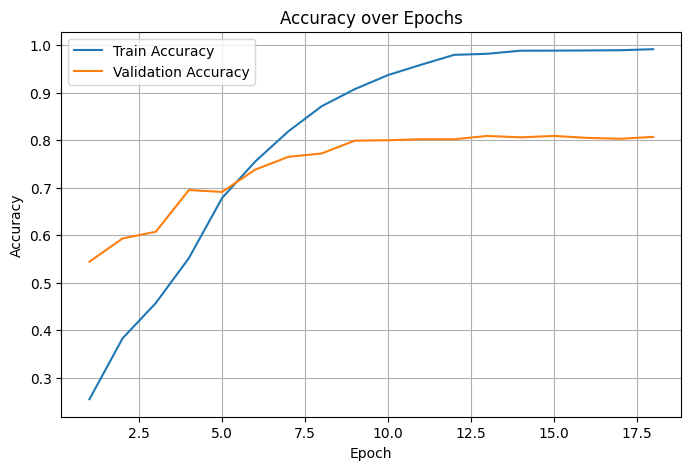

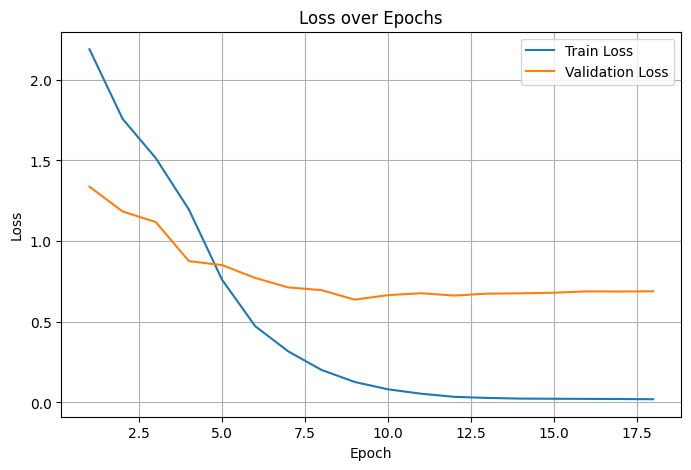

In [9]:
import json
import matplotlib.pyplot as plt

# Load history
with open("/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/resnet50/e25_b32_ftlr5e5/history.json") as f:
    history = json.load(f)

epochs = range(1, len(history['accuracy'])+1)

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs, history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Loaded data from CSV: 18 epochs


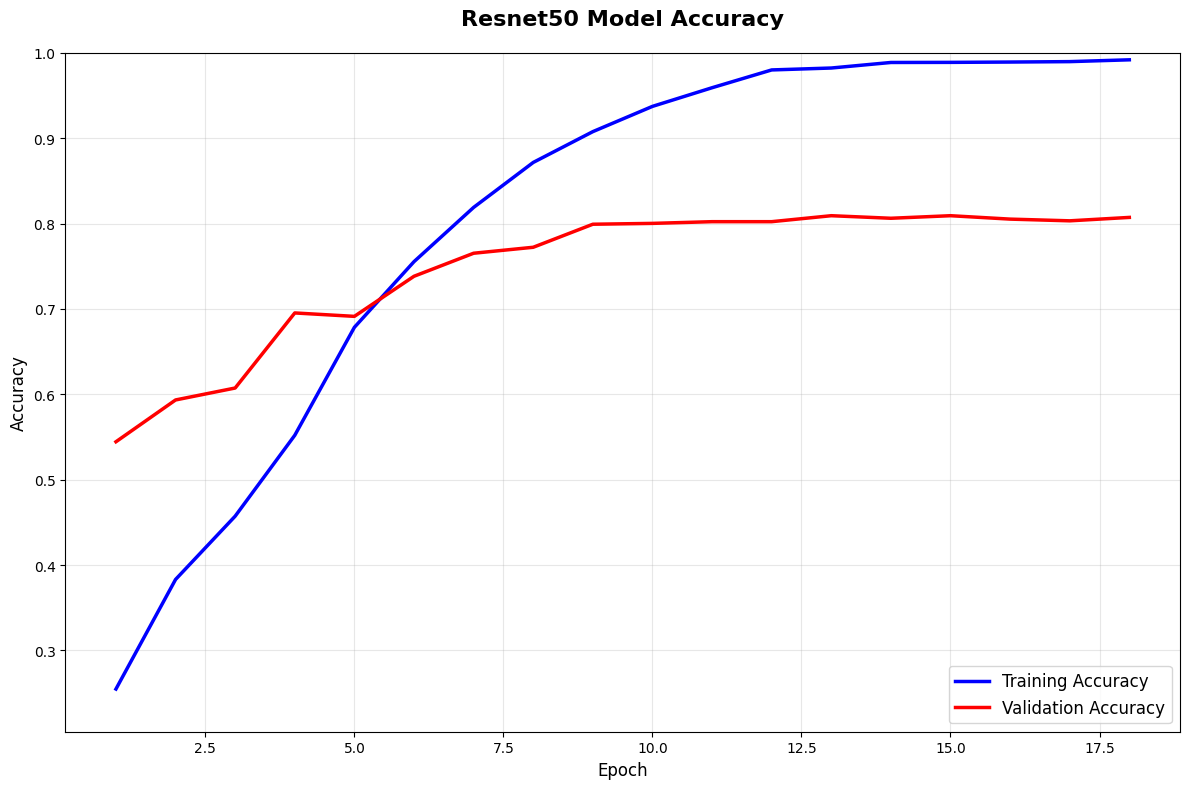

Final Training Accuracy: 0.9918
Final Validation Accuracy: 0.8072
Best Validation Accuracy: 0.8092


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

def plot_accuracy_from_saved_run(run_path):
    """
    Plot accuracy graph from saved resnet50 run
    """
    # Try to load from CSV first
    csv_path = os.path.join(run_path, "/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/resnet50/e25_b32_ftlr5e5/history_epoch.csv")
    json_path = os.path.join(run_path, "/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/resnet50/e25_b32_ftlr5e5/history.json")

    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        epochs = df['epoch'].values
        train_acc = df['accuracy'].values
        val_acc = df['val_accuracy'].values
        print(f"Loaded data from CSV: {len(epochs)} epochs")
    elif os.path.exists(json_path):
        with open(json_path, 'r') as f:
            history = json.load(f)
        train_acc = history.get('accuracy', [])
        val_acc = history.get('val_accuracy', [])
        epochs = range(1, len(train_acc) + 1)
        print(f"Loaded data from JSON: {len(epochs)} epochs")
    else:
        print("No history file found. Using extracted data from log.")
        return

    # Create the accuracy graph
    plt.figure(figsize=(12, 8))

    # Plot training and validation accuracy
    plt.plot(epochs, train_acc, 'b-', linewidth=2.5, label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', linewidth=2.5, label='Validation Accuracy')

    # Customize the graph
    plt.title('Resnet50 Model Accuracy', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right', fontsize=12)

    # Set appropriate limits
    y_min = min(min(train_acc), min(val_acc)) - 0.05
    y_max = max(max(train_acc), max(val_acc)) + 0.05
    plt.ylim(max(0, y_min), min(1.0, y_max))

    # Add grid
    plt.grid(True, alpha=0.3)

    # Improve layout
    plt.tight_layout()

    # Save the plot
    plt.savefig('resnet50_accuracy_graph.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print statistics
    print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Best Validation Accuracy: {max(val_acc):.4f}")

# Use your actual run path
plot_accuracy_from_saved_run('/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/resnet50/e25_b32_ftlr5e5')

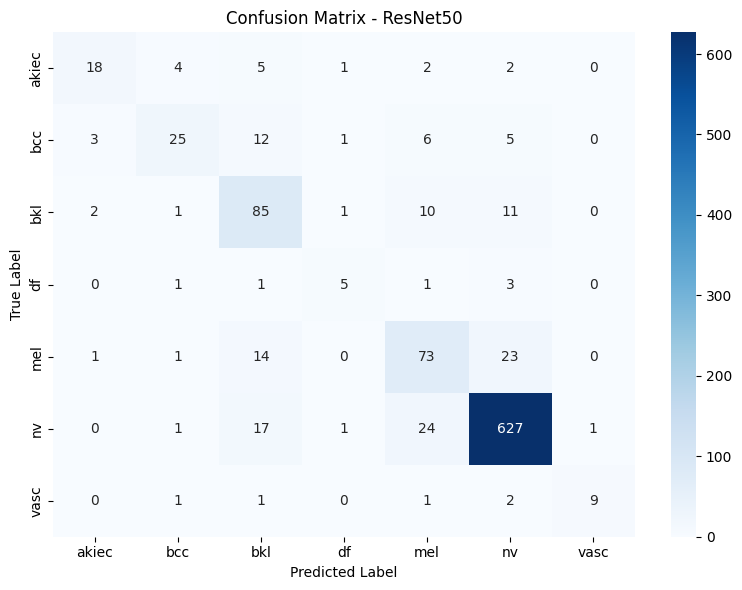

In [11]:
#Confusion Matrix
#Shows how well your model classifies each lesion category.

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

# Load confusion matrix
with open("/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/resnet50/e25_b32_ftlr5e5/metrics.json") as f:
    metrics = json.load(f)

cm = np.array(metrics["confusion_matrix"])
class_names = json.load(open("/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/resnet50/e25_b32_ftlr5e5/classes.json"))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet50")
plt.tight_layout()
plt.show()

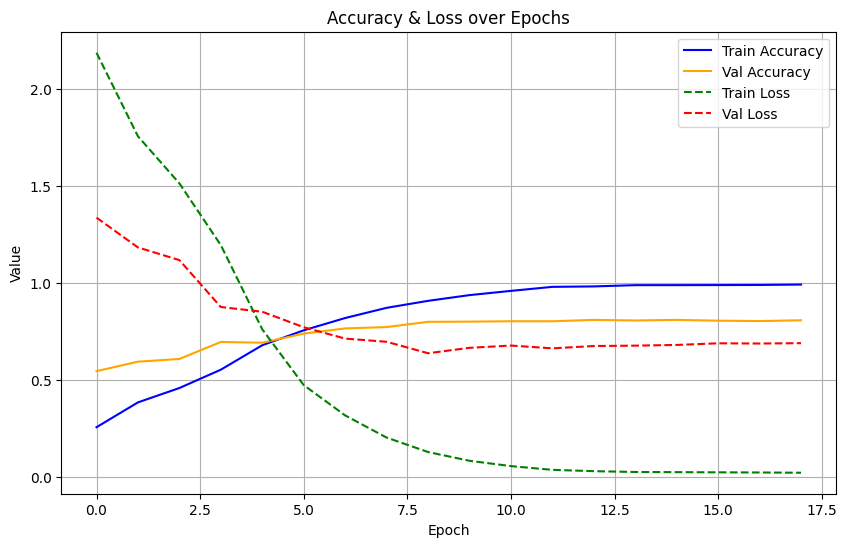

In [12]:
#Training Curves (Accuracy + Loss Combined)
#Overlay both on a single figure for easier trend comparison.

plt.figure(figsize=(10,6))
plt.plot(history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history['val_accuracy'], label='Val Accuracy', color='orange')
plt.plot(history['loss'], label='Train Loss', color='green', linestyle='--')
plt.plot(history['val_loss'], label='Val Loss', color='red', linestyle='--')
plt.title('Accuracy & Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Learning Rate vs Accuracy
#If you use ReduceLROnPlateau, plot how accuracy responds to LR changes.

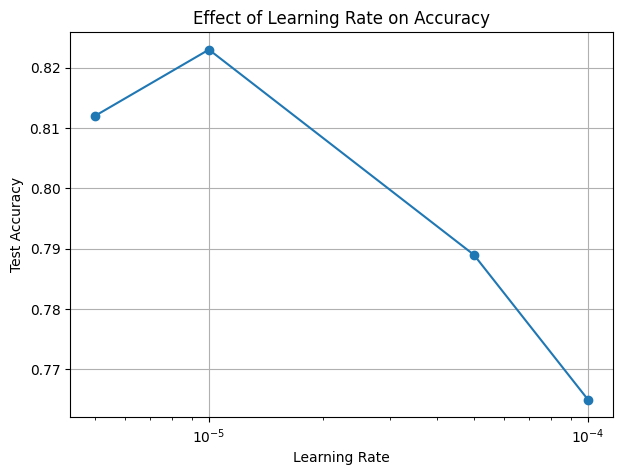

In [13]:
import matplotlib.pyplot as plt

lrs = [1e-4, 5e-5, 1e-5, 5e-6]  # Example learning rates from runs
accs = [0.765, 0.789, 0.823, 0.812]  # Corresponding accuracies

plt.figure(figsize=(7,5))
plt.plot(lrs, accs, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Effect of Learning Rate on Accuracy')
plt.grid(True)
plt.show()

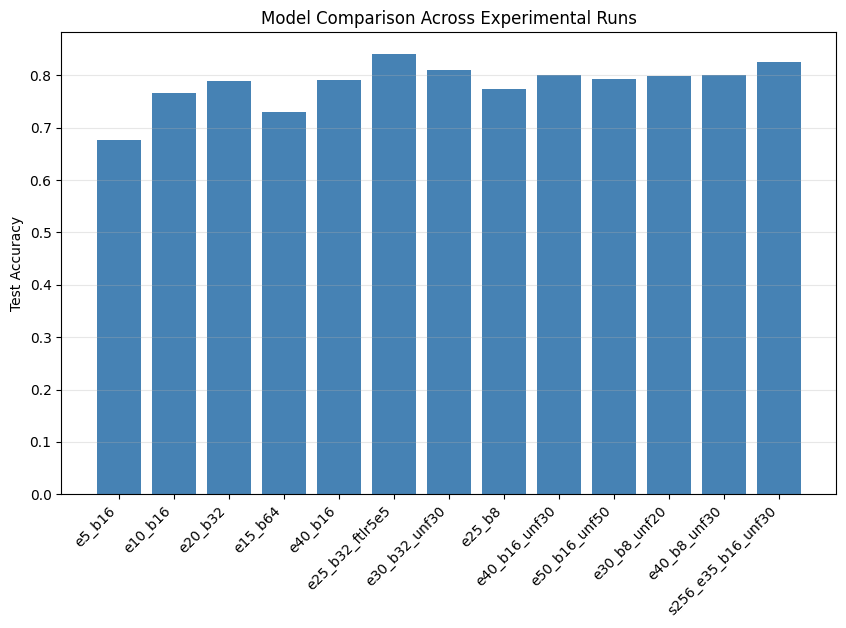

In [15]:
#Bar Chart – Compare Model Runs
#Compare performance across all runs using your experiments_master.csv

import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/SKIN_CANCER_RESULTS/resnet50/resnet50/experiments_master.csv")
plt.figure(figsize=(10,6))
plt.bar(df["run_name"], df["test_acc"], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Test Accuracy")
plt.title("Model Comparison Across Experimental Runs")
plt.grid(axis='y', alpha=0.3)
plt.show()
